# Approximate Nearest Neighbors:

# Image Recommendation System via Collaborative Filtering

# ***Please read the instructions very carefully***
This is a modified version of the previous question and requires you to use an artificial nearest neighbors library

We suggest you to use one of the following:
- [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
- [FAISS](https://github.com/facebookresearch/faiss)
- [Annoy](https://github.com/spotify/annoy.git)

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   ⚠️ The Assignment will be evaluated automatically. Please adhere to taking proper inputs from `config.csv` file. You can change your `config.csv` file to experiment with your code. But at the end, make sure that your outputs are corresponding to input values in `config.csv`
5.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

## About the Dataset
Behance is a community art website where users showcase and discover creative work. Each user is able to “appreciate” (equivalent to a “like” on Instagram or a “react” on Facebook) an image, indicating that they like the image. It is in the website’s best interests to show users pictures that they would like, to keep them engaged for longer. For this question, given a set of pictures that a user has already appreciated, you have to show them a new picture that they would like based on what similar users appreciated.


<br><br>
**The dataset has information of 1 million appreciates of 63,497 users on 178,788 items. The file Behance appreciate 1M has a triplet in each line in the form of (user id, item id, unix timestamp).**

**Task: Take the inputs from the config.csv file and output the recommendations for a particular person**
- Collaborative Filtering is a way to predict items to the user based on the the
user’s history and the history of similar users. The similarity between users can be quantified by the number of images that both the users appreciated.
- The images appreciated by a similar user would be the most suitable images to show a user. Since we can find the similarity between any two users, we would be able to find the “nearest” neighbours of any user, allowing us to use a KNN-based algorithm to recommend new images to a user.
- Since people do not like seeing pictures that they have seen already. Make sure that you do not recommend pictures that a user has appreciated already.
- Output the final response will be saved in the file named ```config['output_file']```.


**Output file format:**
Populate the output file with images that the user has not seen of the k most
similar users, in descending order of their similarity. Each line in the output
file should be a duplet in the form of (item id, user id), where the user id is the
id of the kth similar user. The order of the images corresponding to the same
similar user would not matter. The output file would look something like this:
```
item_id_1_of_1st_similar_user 1st_most_similar_user_id
item_id_2_of_1st_similar_user 1st_most_similar_user_id
item_id_3_of_1st_similar_user 1st_most_similar_user_id
...
item_id_1_of_2nd_similar_user 2nd_most_similar_user_id
item_id_2_of_2nd_similar_user 2nd_most_similar_user_id
item_id_3_of_2nd_similar_user 2nd_most_similar_user_id
...
item_id_1_of_kth_similar_user kth_most_similar_user_id
item_id_2_of_kth_similar_user kth_most_similar_user_id
item_id_3_of_kth_similar_user kth_most_similar_user_id
```

You may use any other recommendation system that you wish to use. However,
evaluation script will score your submission by measuring the similarity between
users with the number of common images they appreciated.
The dataset was extracted using Behance’s API as a part of the paper
“Vista: A visually, socially, and temporally-aware model for artistic
recommendation, RecSys, 2016”. Check out this [Google Drive folder](https://drive.google.com/drive/folders/0B9Ck8jw-TZUEc3NlMjVXdDlPU1k?resourcekey=0-6_8ykn0o4fLc5fuTEm91xA) for
more information about the dataset.


Have fun! The users are waiting to see new pictures!

### Import necessary libraries

In [ ]:
!pip install scann
import numpy as np
import pandas as pd
import scann
import math
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from numpy import dot
from numpy.linalg import norm

In [16]:
# Config Generation Sample Code.
# ⚠️ Only for experimentation on your side.
# ⚠️ Should be commented during submission.

# df = pd.DataFrame(data=[{'id':276633,
#                   'k':5,
#                   'dataset_file':'./Behance_appreciate_1M',
#                   'output_file':'./output.txt'}])
# df.to_csv('config.csv')

In [17]:
config = pd.read_csv('config.csv').iloc[0]

In [18]:
config

Unnamed: 0                            0
id                               276633
k                                     5
dataset_file    ./Behance_appreciate_1M
output_file                ./output.txt
Name: 0, dtype: object

In [19]:
user = config['id']
k_value = config['k']

### Read the Data

In [20]:
with open(config['dataset_file'], 'r') as inFile:
    appreciate_data = inFile.readlines()

In [21]:
# your code here

### Initialize a dictionary to store the item_ids that a user likes

### Go through each line of the input file and construct the user_likes dictionary

In [22]:
user_likes = dict()
users = set()
images = set()
user_index = dict()
index_user = dict()
image_index = dict()

In [23]:
for line in appreciate_data:
    line = line.strip()
    
    user_id = int(line.split()[0])
    try:
      item_id = int(line.split()[1])
    except:
      continue

    if user_id not in user_likes:
        user_likes[user_id] = list()
        users.add(user_id)
    images.add(item_id)
    
    user_likes[user_id].append(item_id)

- Creating dictionary to map user_id to index of an array and vice-versa.
- Creating dictionary to map image item_id to index of its array.

In [24]:
for i,u in enumerate(users):
    user_index[u] = i
    index_user[i] = u

for i,im in enumerate(images):
    image_index[im] = i

Creating vectors of sparse matrix, viz. user,item,value

In [25]:
user_array = list()
item_array = list()
value_array = list()

for uid in user_likes:
    for iid in user_likes[uid]:
        user_array.append(user_index[uid])
        item_array.append(image_index[iid])
        value_array.append(1)


- Calculation of CSR and SVD

In [26]:
csr = csr_matrix((value_array, (user_array, item_array)), dtype=np.int8)
svd = TruncatedSVD(n_components=1000, random_state=17)
csr = svd.fit_transform(csr)

### Use your choice of Approximate Nearest Neigbor after Collaborative Filtering to find nearest neighbors

In [27]:

def neighbors(user,k_value):
    """ returns an iterable object (like list or generator) """
    out = csr / np.linalg.norm(csr, axis=1)[:, np.newaxis]

    searcher = scann.scann_ops_pybind.builder(out , 10, "dot_product").tree(num_leaves=math.floor(math.sqrt(len(user_index))), num_leaves_to_search=100, training_sample_size=len(user_index)).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

    neighbours, dist = searcher.search(out[user_index[user]] , final_num_neighbors=k_value + 21)

    final_users = list()
    user_like_set = set(user_likes[user])
    for u_idx in neighbours:
        if index_user[u_idx]==user:
            continue
        if len(final_users)==k_value:
            break

        s = set(user_likes[index_user[u_idx]])
        if len(s.difference(user_like_set)) != 0:
            final_users.append(index_user[u_idx])

    return final_users
    # return list(map(lambda x:index_user[x], neighbours))


### Answer the following questions:

#### Q1. **Explain how your choice of library works**

ScaNN performs vector search in three phases:<br>

<b>Partitioning:</b> It partitions the dataset during training time, and at query time, it selects the top partitions to pass onto the scoring stage.<br>

<b>Scoring:</b> It computes the distances from the query to all datapoints in the dataset or all datapoints in a partition to search. These distances aren't necessarily exact.<br>

<b>Rescoring:</b> It takes the best k' distances from scoring and re-computes these distances more accurately. From these k' re-computed distances the top k are selected.
<br>

#### Q2. **Compare your choice of library with vanilla KNN.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***


<p>
Time complexity of vanilla Knn is O(n + k)
where<br>
n is the number of users<br>
k is the K closest neigbours as per distance
<br>

Time Complexity of SCANN is O(n*d + k) <br>
where 
<br>
n is the number of users <br>
d is the number of images <br>
k is the K closest neigbours as per distance


#### Q3. **Compare your choice of library with implementation of ScaNN, faiss and annoy.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***

*ScaNN Currently is the best out of all the 3 in terms of queries per second and recall. As you can see in the below image, for the same dataset, ScaNN gives better results for higher the values of queries. It can handle more queries with better recall.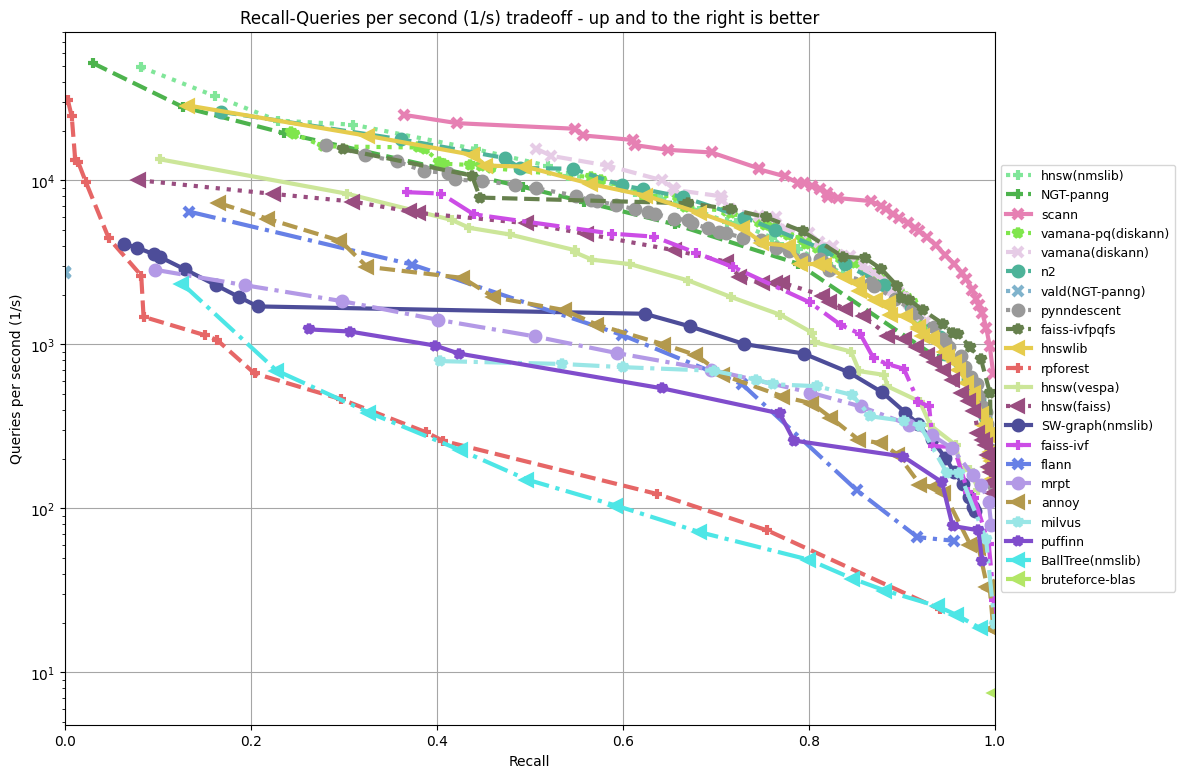*

### Open the output file to write all the lines to the file

In [28]:
outFile = open(config['output_file'], 'w')

for n_user in neighbors(user,k_value):
    # user_id = list(user_likes.keys())[n_user]
    for item_id in user_likes[n_user]:
        if(item_id not in user_likes[user]):
            outFile.write(str(item_id) + ' ' + str(n_user) + '\n')

outFile.close()